In [1]:
#Libraries imports
import torch
import edward
from edward.models import Categorical, Mixture, Normal
import pandas as pd
from sklearn.metrics import mean_squared_error
import time
import numpy as np
import random
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
#Load test data and necessary data for prediction inspection

with open('/tmp/PredictionPDF.pt','rb') as f:
         probs = torch.load(f)
with open('/tmp/PDFCenters.pt','rb') as f:
         centers = torch.load(f)
with open('../data/Wall/test_data_2sensors_1hot.pt','rb') as f:
      test_ = torch.load(f)


#Load N test points
N = 10
test_data = test_[random.sample(range(0, len(test_)), N),:] 

In [4]:
#Inspect posterior predictive distribution

y_post = []
sigma_y = 1.0
n_samples = 100

t0 = time.time()
for i in range(len(test_data)):
    print("Forming the posterior predictive distribution for test data point", i+1, "/", len(test_data), "...")
    y_post.append(Mixture(Categorical(probs = probs[i]), 
                  [Normal(loc=centers[i][j], scale=sigma_y) for j in range(len(centers[i]))]))
    
print("Took altogether", np.int(time.time() - t0), "secs.")

t0 = time.time()
print("Sampling the posterior predictive distribution for", len(test_data), "test data points...")
posteriorsamplenodes = tf.stack([y_post[i].sample(n_samples) for i in range(len(test_data))], axis=1)
with tf.Session().as_default():
     posteriorsamples = pd.DataFrame(posteriorsamplenodes.eval())


print("Took", np.int(time.time() - t0), "secs.")

('Forming the posterior predictive distribution for test data point', 1, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 2, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 3, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 4, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 5, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 6, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 7, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 8, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 9, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 10, '/', 10, '...')
('Took altogether', 9, 'secs.')
('Sampling the posterior predictive distribution for', 10, 'test data points.

In [12]:
#Inspect prediction statistics

predictions = posteriorsamples.mean()
predictions_low = posteriorsamples.quantile(0.01)
predictions_high = posteriorsamples.quantile(0.99)
print(predictions)
results = pd.DataFrame()
results['Bayesian_prediction'] = predictions
print(predictions)
results['Bayesian_prediction_low'] = predictions_low
results['Bayesian_prediction_high'] = predictions_high

print("MSE on test data for Bayesian neural network:")
print(np.round(mean_squared_error(results['Bayesian_prediction'], test_data[:,2]), 2))
results = results.applymap(lambda x: np.round(x,2))
results

0    0.338026
1    0.453180
2    0.276261
3    0.480617
4    0.256703
5    0.383373
6    0.493299
7    0.551849
8    0.310715
9    0.563024
dtype: float32
0    0.338026
1    0.453180
2    0.276261
3    0.480617
4    0.256703
5    0.383373
6    0.493299
7    0.551849
8    0.310715
9    0.563024
dtype: float32
MSE on test data for Bayesian neural network:
0.18


,Bayesian_prediction,Bayesian_prediction_low,Bayesian_prediction_high
0,0.34,-1.94,2.43
1,0.45,-1.92,2.49
2,0.28,-2.29,2.25
3,0.48,-2.22,3.07
4,0.26,-3.34,2.31
5,0.38,-1.50,2.85
6,0.49,-2.16,2.92
7,0.55,-1.75,3.53
8,0.31,-1.87,2.49
9,0.56,-2.32,3.43


7
[ 0.8309094  -1.7368797   3.5057988   2.6058297   0.07284048 -1.2046102
  2.3075285   1.8855275  -1.1582946   0.18892586  0.86931306  2.5168047
  1.4492276   0.277875    0.9964552   0.7615038  -1.0209935  -0.14774188
 -0.05826478  1.9069946   0.07012901  0.5315925   1.6878874   1.1609392
  0.2988209  -1.6288211  -1.466791    0.32624173  0.5965077   1.0545971
  2.9349675  -0.99061465 -0.8047083   2.721283    1.036118   -0.2181027
  1.3310297   0.3886668  -0.7199236   0.7175065   3.1307187   0.33818337
  0.5116917   0.94099325  0.03916761  0.6769243  -0.85956657  0.3274856
 -0.45756724  0.13076651  0.8815958   0.9146383   1.2293098  -0.4999794
 -0.23694158 -0.92037326  1.1131026   1.1130503  -0.6983726   1.3586205
  0.22122134 -0.1865747   0.4608035  -0.06176007  3.5247478   1.0528097
 -0.78494585  1.1665434   1.0426062   0.64052516  1.0915117  -3.148363
  0.27106726  0.40288338  1.9465013   0.91879064 -0.17228842 -0.14868534
  2.126967   -1.4766551   0.23941348  2.465152    3.554009  

Text(0.5,1,'Results for test data point 7')

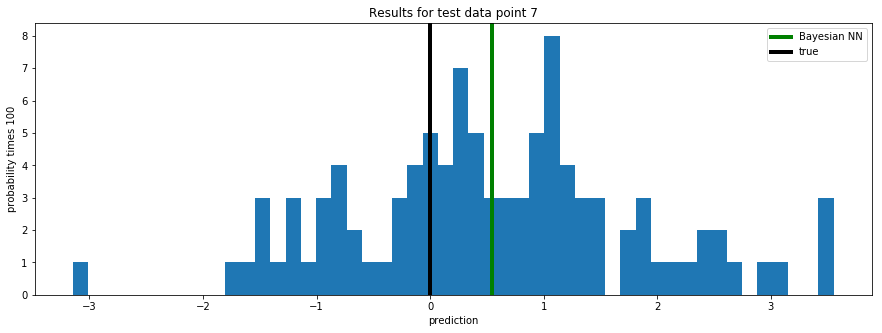

In [13]:
#Visualise one (random) prediction and associated uncertainty

test_sample_number = np.random.choice(range(len(test_data)))
print(test_sample_number)
print((posteriorsamples[test_sample_number].values))
plt.figure(figsize=(15,5))

_, _, histogram = plt.hist(posteriorsamples[test_sample_number].values, bins=50)
plt.xlabel("prediction")
plt.ylabel("probability times " + str(n_samples))
plt.axvline(results.loc[test_sample_number, 'Bayesian_prediction'], color='g', linewidth=4, label="Bayesian NN")
plt.axvline(test_data[test_sample_number,2], color='k', linewidth=4, label="true")
plt.legend()
plt.title("Results for test data point " + str(test_sample_number))